In [1]:
#%matplotlib nbagg
#Import required libraries
# from serial import Serial
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
# from drawnow import drawnow, figure
from scipy import stats
from scipy.signal import butter, lfilter, freqz, filtfilt, medfilt, resample
from scipy.fft import fft, fftfreq
from sklearn.metrics import mean_squared_error
import pandas as pd
import math
from matplotlib import rcParams
import copy
from tqdm import tqdm
# rcParams.update({'figure.autolayout': True})

# Classes

In [2]:
class RunningMedian:
    def __init__(self,window_size):
        self.window_size = window_size
        self.values = []
        self.sortIdx = []
        self.filtered_values = []
        self.values_sorted = []
        
    def qsort(self,inlist):
        if inlist == []: 
            return []
        else:
            pivot = inlist[0]
            lesser = self.qsort([x for x in inlist[1:] if x < pivot])
            greater = self.qsort([x for x in inlist[1:] if x >= pivot])
            return lesser + [pivot] + greater
        
    def add(self,val):
        self.values.append(val)
        if len(self.values)>self.window_size:
            self.values.pop(0)


    def findAvgMedian(self,mean_size):
        self.values_sorted = self.qsort(self.values)
        
        if len(self.values_sorted)<mean_size:
            return np.mean(self.values_sorted)
        else:
            median = math.floor(len(self.values_sorted)/2)
            half_mean_size = math.floor(mean_size/2)
            start_indx = median-half_mean_size
            end_indx = median+half_mean_size
            return np.mean(self.values_sorted[start_indx:end_indx])

        
class FilterWindow:
    def __init__(self,time_window_size,fps):
        self.time_window_size = time_window_size
        self.filter_window = []
        self.fps = fps
        self.window_size = int(self.time_window_size*self.fps)
    def get_filter_window(self,value):
        self.filter_window.append(value)
        if len(self.filter_window)>self.window_size:
            self.filter_window.pop(0)
        return self.filter_window
  

# Functions

In [3]:
def butter_filter(data, cutoff, order, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff)  # , btype='low', analog=False
#     b, a = butter(3, 0.1)
    y = filtfilt(b, a, data)
    return y

def get_med_avg_data(csv_data):
    window_size = 50 #OPTIMIZE
    avg_med_window_size = 10 #OPTIMIZE
    avg_overall_window_size = 10 #OPTIMIZE
    avg_weights = []
    
    rn = RunningMedian(window_size)
    
    for i in tqdm(range(len(csv_data))):
#     for i in range(len(csv_data)):
        #Get current value
        val = csv_data[i]
        
        
        avg_count = avg_overall_window_size 
        total_weight = 0
        
        #Collect 10 dp
        for j in range(avg_count):
            val = csv_data[i]
            
            #Find avg median
            rn.add(val)
            avg_med_val = rn.findAvgMedian(avg_med_window_size)
            total_weight = total_weight+avg_med_val

        #Find overall average
        avg_weight = total_weight/avg_count
        avg_weights.append(avg_weight)

    return avg_weights


def get_rolling_slope(csv_data, datapnt_delay, calibration_factor):
    window_width_raw = 10
    window_width_flowrate = 25
    cutoff_1 = 0.1 # 0.02
    order_1 = 3 # 12
    fps = 1000/datapnt_delay

 
    raw_data = []
    flow_rate = []
    flow_rate_filtered = []

    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width_raw*fps:
            curr_window_raw = raw_data[int(-window_width_raw*fps):]
#             curr_window_raw_filtered = butter_filter(curr_window_raw, cutoff_1, order_1, fps)
            curr_window_raw_filtered = curr_window_raw
            x =list(range(len(curr_window_raw_filtered)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window_raw_filtered)
             
            #Convert light results
            syringe_rad = 21.7/2 #Syringe radius in mm
            syringe_area = math.pi*(syringe_rad ** 2)
            density = 1 #1g/mL
            curr_flowrate = (1/density)*curr_slope*60*fps*-1  #convert from g/s to mL/min
            
            flow_rate.append(curr_flowrate)
        else:
            flow_rate.append(0)
                
        cutoff_2 = 0.6
        order_2 = 6
        if len(flow_rate) > (window_width_raw+window_width_flowrate)*fps:
            curr_start = int(-window_width_flowrate*fps)
            curr_window_flowrate = flow_rate[curr_start:]
            
#             curr_window_flowrate_filtered = butter_filter(curr_window_flowrate, cutoff_2, order_2, fps)[0]
            curr_window_flowrate_filtered = stats.trim_mean(curr_window_flowrate,0.3)
            
#             calibration_factor = 1.2  #0.54
            curr_window_flowrate_filtered = calibration_factor * curr_window_flowrate_filtered
            flow_rate_filtered.append(curr_window_flowrate_filtered)
        
        else:
            flow_rate_filtered.append(0)
            
    
    return flow_rate_filtered, flow_rate  # returning flow_rate is just for testing
    #return flow_rate
        

def get_rolling_slope_measured(csv_data,time):
    #Sampled every 5 seconds - real data
    fps = 1
    window_width = 15
    slope = []
    raw_data = []
    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width*fps:
            curr_window = raw_data[int(-window_width*fps):]
            x =list(range(len(curr_window)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
            slope.append(curr_slope)
        else:
            slope.append(0)
         
    #Calculate flow rate depending on sensor data type
    density_milk = 1 
    conversion_factor = 60
    time_interval = 5 #5s between data recordings
    flow_rate = np.multiply(slope,(1/time_interval*(1/density_milk)*conversion_factor))
    
    data_mean, data_std = np.mean(flow_rate), np.std(flow_rate)
    # identify outliers
    cut_off = data_std * 0.6
    lower, upper = data_mean - cut_off, data_mean + cut_off
    indexes_to_remove = np.where((flow_rate< lower) | (flow_rate > upper))[0]
  
    flow_rate_filtered = np.delete(flow_rate, indexes_to_remove)#indexes_to_remove[0])
    time_filtered = np.delete(np.array(time),indexes_to_remove)
        
    return flow_rate_filtered,time_filtered



def get_time(csv_data, datapnt_delay):
    fps = 1000/datapnt_delay
    time = np.multiply(range(0,len(csv_data)),(1/fps))
    return time


def process_csv(csv_path):
    file = open(csv_path)
    csvreader = csv.reader(file)
    csv_data = np.asarray(list(csvreader))
    csv_data = np.asfarray(csv_data,float).flatten()
    return csv_data

# Import

In [25]:
# Path to folder containing sensor data (csv file format)
# csv_data_folder = r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-03-04 Load sensor trials'
# csv_data_folder = r'C:\Users\anne\Projects\FYDP\fydp-neofeed\sensor_data\2022-03-04 Load sensor trials'
csv_data_folder = r'C:\Users\anne\Projects\FYDP\fydp-neofeed\sensor_data\raspberrypi_data'
# csv_data_folder = r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\raspberrypi_data'

#Read sensor data

sensor_height = 'low'

if sensor_height == 'high':
    #high
    csv_name_30_light1_filename = r'total_avg_weights--2022-03-23 21-40-13.264268.csv'
    csv_name_30_light2_filename = r'total_avg_weights--2022-03-23 21-59-10.149583.csv'
    csv_name_30_light3_filename = r'total_avg_weights--2022-03-23 22-18-40.139782.csv'
    csv_name_30_light_measured = r'2022-03-24 - Unfiltered sensor - Higher.csv'

elif sensor_height == 'low':
    #low
    csv_name_30_light1_filename = r'total_avg_weights--2022-03-23 20-46-21.145784.csv'
    csv_name_30_light2_filename = r'total_avg_weights--2022-03-23 21-17-11.310781.csv'
    csv_name_30_light3_filename = r'total_avg_weights--2022-03-23 22-47-43.773810.csv'
    csv_name_30_light_measured = r'2022-03-24 - Unfiltered sensor - Lower.csv'


datapnt_delay = 90

csv_path_30_light1 = os.path.join(csv_data_folder, csv_name_30_light1_filename)
csv_path_30_light2 = os.path.join(csv_data_folder, csv_name_30_light2_filename)
csv_path_30_light3 = os.path.join(csv_data_folder, csv_name_30_light3_filename)


csv_data_30_light1 = process_csv(csv_path_30_light1)#[1000:12000]
csv_data_30_light2 = process_csv(csv_path_30_light2)#[1000:17500]
csv_data_30_light3 = process_csv(csv_path_30_light3)


time_30_light1 = get_time(csv_data_30_light1, datapnt_delay)
time_30_light2 = get_time(csv_data_30_light2, datapnt_delay)
time_30_light3 = get_time(csv_data_30_light3, datapnt_delay)


csv_path_30_light_measured = os.path.join(csv_data_folder, 'Scale_data', csv_name_30_light_measured)
csv_data_30_light_measured = pd.read_csv(csv_path_30_light_measured)

time_30_light_measured1 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 1'].notna()]
time_30_light_measured2 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 2'].notna()]
time_30_light_measured3 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 3'].notna()]



csv_data_30_light_measured1 = csv_data_30_light_measured['Trial 1'].dropna()
csv_data_30_light_measured2 = csv_data_30_light_measured['Trial 2'].dropna()
csv_data_30_light_measured3 = csv_data_30_light_measured['Trial 3'].dropna()

#  Plot Raw Data

Text(0.5, 0, 'Time (s)')

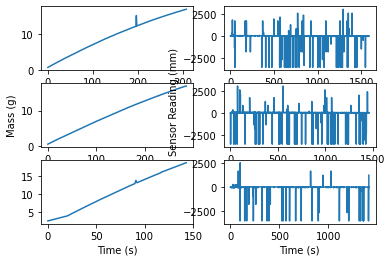

In [26]:
#Read sensor data
fig, axs = plt.subplots(3,2)

#axs[0,0].plot(time_30_light_measured1,csv_data_30_light_measured1)
axs[0,0].plot(csv_data_30_light_measured1)
axs[0,1].plot(time_30_light1,csv_data_30_light1)

#axs[1,0].plot(time_30_light_measured2,csv_data_30_light_measured2)
axs[1,0].plot(csv_data_30_light_measured2)

axs[1,0].set_ylabel('Mass (g)')
axs[1,1].plot(time_30_light2,csv_data_30_light2)
axs[1,1].set_ylabel('Load Sensor Reading (mm)')

# #axs[2,0].plot(time_30_light_measured3,csv_data_30_light_measured3)
axs[2,0].plot(csv_data_30_light_measured3)
axs[2,1].plot(time_30_light3,csv_data_30_light3)
axs[2,0].set_xlabel('Time (s)')
axs[2,1].set_xlabel('Time (s)')

# Plot Med Avg Data 

100%|███████████████████████████████████████████████████████████████████████████| 15715/15715 [02:02<00:00, 127.97it/s]


Text(0.5, 0, 'Time (s)')

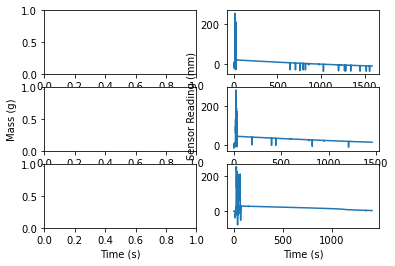

In [27]:
med_avg_1 = get_med_avg_data(csv_data_30_light1)
med_avg_2 = get_med_avg_data(csv_data_30_light2)
med_avg_3 = get_med_avg_data(csv_data_30_light3)


fig, axs = plt.subplots(3,2)

#axs[0,0].plot(time_30_light_measured1,csv_data_30_light_measured1)
#axs[0,0].plot(csv_data_30_light_measured1)
axs[0,1].plot(time_30_light1,med_avg_1)

#axs[1,0].plot(time_30_light_measured2,csv_data_30_light_measured2)
#axs[1,0].plot(csv_data_30_light_measured2)

axs[1,0].set_ylabel('Mass (g)')
axs[1,1].plot(time_30_light2,med_avg_2)
axs[1,1].set_ylabel('Load Sensor Reading (mm)')

# #axs[2,0].plot(time_30_light_measured3,csv_data_30_light_measured3)
# axs[2,0].plot(csv_data_30_light_measured3)
axs[2,1].plot(time_30_light3,med_avg_3)
axs[2,0].set_xlabel('Time (s)')
axs[2,1].set_xlabel('Time (s)')

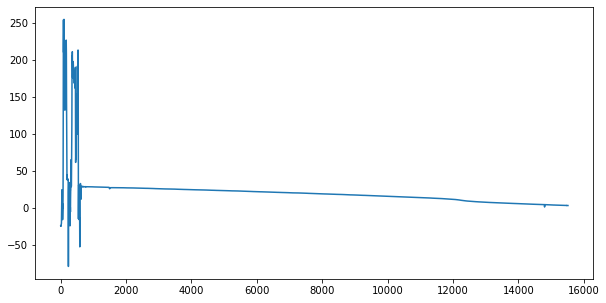

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(med_avg_3[200:])
# plt.ylim([10,35])

In [29]:
print(len(med_avg_1))
print(len(med_avg_2))
print(len(med_avg_3))
# med_avg_1

17631
16222
15715


## save processed signals to individual csv files

In [30]:
np.savetxt(csv_name_30_light1_filename + '_' + sensor_height + '_PROCESSED.csv', med_avg_1, delimiter=',')
np.savetxt(csv_name_30_light2_filename + '_' + sensor_height + '_PROCESSED.csv', med_avg_2, delimiter=',')
np.savetxt(csv_name_30_light3_filename + '_' + sensor_height + '_PROCESSED.csv', med_avg_3, delimiter=',')

In [31]:
# df = pd.concat([pd.DataFrame(time_30_light1), pd.DataFrame(med_avg_1), pd.DataFrame(med_avg_2), pd.DataFrame(med_avg_3)], axis=1)
# df.columns = ['Time', 'Trial 1', 'Trial 2', 'Trial 3']
# df.to_csv("2022-03-24_Processed_sensor_data_Higher.csv", index=False)

## Checking if noise has a frequency

N= 15715 , T= 0.09


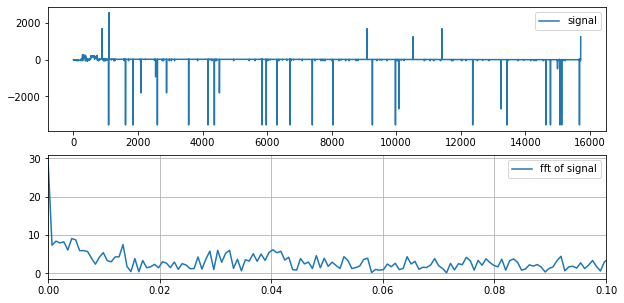

In [32]:
# temp_sig = flow_rate_light1_scaled[5950:-403]
# temp_sig = flow_rate_light2_scaled  # [2500:-6]
temp_sig = csv_data_30_light3 # [1000:12000]
# temp_sig = flow_rate_light2_RAW[50:700]
N = len(temp_sig)
T = datapnt_delay/1000 # time_30_light2[1] - time_30_light2[0]  # 1.0 / 800.0  # difference between x values
print('N=', N, ', T=', T)

# x = np.linspace(0.0, N*T, N, endpoint=False)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(temp_sig)
xf = fftfreq(N, T)[:N//2]
# import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(211)
# plt.title('flow_rate_light2_RAW[50:700]')
plt.plot(temp_sig, label='signal')
plt.legend()
plt.subplot(212)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label='fft of signal')
plt.legend()
plt.grid()
# plt.ylim([0,10])
plt.xlim([0, 0.1])
plt.show()

N= 15715 , T= 0.09


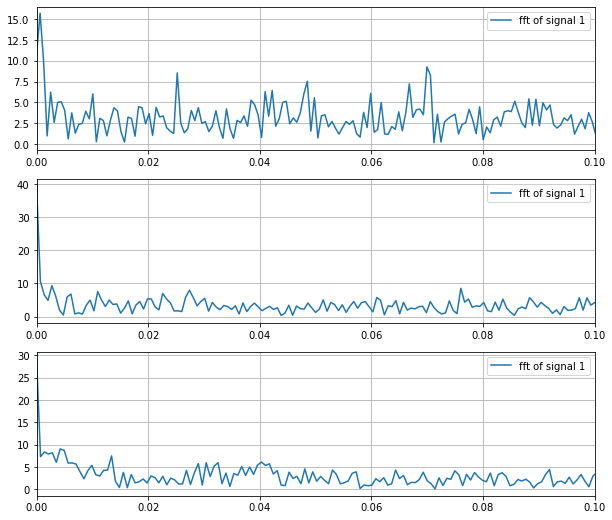

In [33]:
N = len(temp_sig)
T = datapnt_delay/1000 # time_30_light2[1] - time_30_light2[0]  # 1.0 / 800.0  # difference between x values
print('N=', N, ', T=', T)


plt.figure(figsize=(10,9))

plt.subplot(311)
yf_1 = fft(csv_data_30_light1)
xf_1 = fftfreq(len(csv_data_30_light1), T)[:N//2]
plt.plot(xf_1, 2.0/N * np.abs(yf_1[0:N//2]), label='fft of signal 1')
plt.legend()
plt.grid()
# plt.ylim([0,10])
plt.xlim([0, 0.1])
plt.legend()

plt.subplot(312)
yf_2 = fft(csv_data_30_light2)
xf_2 = fftfreq(len(csv_data_30_light2), T)[:N//2]
plt.plot(xf_2, 2.0/N * np.abs(yf_2[0:N//2]), label='fft of signal 1')
plt.legend()
plt.grid()
# plt.ylim([0,10])
plt.xlim([0, 0.1])
plt.legend()
               
plt.subplot(313)
yf_3 = fft(csv_data_30_light3)
xf_3 = fftfreq(len(csv_data_30_light3), T)[:N//2]
plt.plot(xf_3, 2.0/N * np.abs(yf_3[0:N//2]), label='fft of signal 1')
plt.legend()
plt.grid()
# plt.ylim([0,10])
plt.xlim([0, 0.1])
plt.legend()

plt.show()